<div class="alert alert-block alert-info"> <b>NOTE:</b> This jupyter notebook is a companion to the <b>comparing_annotations.md</b> file. For more details read that documentation first and then come back here. </div>   
   
# Vs. reference performance comparison
The code for the comparison uses a lot of files that won't be uploaded here. This is simply an **example** and a **documentation** of how to compare and plot gene annotations from different sources/gene callers and the reference. This notebook just includes examples from plant species used for evaluation of Helixer and the final summary plot for all lineages. The plots are shown in a low resolution to keep the notebook file size smaller.  
   
The expected file structure the code is working with is as follows:

Each species folder is structured as follows (only files important for the analysis are mentioned):

## Parsing the data
Now that we know how the directories we will be using are structured, we can start with parsing the F1 statistics file `F1_summary.csv` and the phase confusion matrix file `confusion_matrix.csv` for every gene caller, Helixer (base-wise and post-processed predictions), AUGUSTUS and GeneMark.

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from pandas.plotting import parallel_coordinates

import seaborn as sns
import re
from collections import defaultdict

The genic level metrics can be read directly from the file.

In [2]:
def read_n_clean(csvfile):
    df = pd.read_csv(csvfile)
    df = df.dropna(how='all')
    df.index = df.iloc[:,0]
    return df

In [3]:
path = '../summary/plant/Arachis_hypogaea/vs_ref/helixer/all/genic_class/F1_summary.csv'
df = read_n_clean(path)
df

,Unnamed: 0,norm. H,Precision,Recall,F1-Score
Unnamed: 0,,,,,
ig,ig,NaN,0.9885,0.9878,0.9882
utr,utr,NaN,0.5958,0.7325,0.6571
exon,exon,NaN,0.8120,0.8354,0.8236
intron,intron,NaN,0.7879,0.7531,0.7701
legacy_cds,legacy_cds,NaN,0.8058,0.7931,0.7994
sub_genic,sub_genic,NaN,0.7977,0.7852,0.7914
genic,genic,NaN,0.7696,0.7792,0.7744


The phase level metrics need to be calculated from the confusion matrix.

In [4]:
# from Helixer/helixer/prediction/Metrics with modification to work in isolation
def precision_recall_f1(tp, fp, fn):
    if (tp + fp) > 0:
        precision = tp / (tp + fp)
    else:
        precision = 0.0  # avoid an error due to division by 0
    if (tp + fn) > 0:
        recall = tp / (tp + fn)
    else:
        recall = 0.0
    if (precision + recall) > 0:
        f1 = 2 * precision * recall / (precision + recall)
    else:
        f1 = 0.0
    return precision, recall, f1

def add_to_scores(d):
    """adds precision, recall, and f1 to input dictionary, d"""
    metrics = precision_recall_f1(d['TP'], d['FP'], d['FN'])
    d['precision'], d['recall'], d['f1'] = metrics


def get_scores(cm):
    cm = np.array(cm)
    scores = defaultdict(dict)
    # single column metrics
    names = ['no_phase', 'phase_0', 'phase_1', 'phase_2']

    for col in range(4):
        name = names[col]
        d = scores[name]
        not_col = np.arange(4) != col
        # reference annotation is in dim 0, prediction in dim 1
        d['TP'] = cm[col, col]
        d['FP'] = np.sum(cm[not_col, col])
        d['FN'] = np.sum(cm[col, not_col])

        add_to_scores(d)
        
        
    d = scores['phase']
    for base_metric in ['TP', 'FP', 'FN']:
        d[base_metric] = sum([scores[m][base_metric] for m in ['phase_0', 'phase_1', 'phase_2']])
    add_to_scores(d)

    return scores
    
def read_n_clean2(csvfile):
    predf = pd.read_csv(csvfile, index_col=0)
    df = pd.DataFrame(get_scores(predf))
    return df

In [5]:
path = '../summary/plant/Arachis_hypogaea/vs_ref/helixer/all/phase/confusion_matrix.csv'
df = read_n_clean2(path)
df

,no_phase,phase_0,phase_1,phase_2,phase
TP,4.380358e+09,2.317496e+07,2.318021e+07,2.317274e+07,6.952792e+07
FP,1.485415e+07,4.539986e+06,4.566149e+06,4.545084e+06,1.365122e+07
FN,1.297633e+07,5.177403e+06,5.172062e+06,5.179578e+06,1.552904e+07
precision,9.966204e-01,8.361900e-01,8.354325e-01,8.360231e-01,8.358817e-01
recall,9.970464e-01,8.173908e-01,8.175786e-01,8.173138e-01,8.174277e-01
f1,9.968333e-01,8.266835e-01,8.264091e-01,8.265626e-01,8.265517e-01


In [6]:
# import all species metrics, genic and phase
def import_full_species(basedir):
    vs_ref_dfs = {}
    for species in os.listdir(basedir):
        vs_ref_dfs[species] = {}
        try:
            for method in os.listdir(os.path.join(basedir, species, 'vs_ref')):
                vs_ref_dfs[species][method] = {}
                vs_ref_dfs[species][method]['genic_class'] = \
                    read_n_clean(os.path.join(basedir, species, 'vs_ref', method, 'all/genic_class/F1_summary.csv'))
                vs_ref_dfs[species][method]['phase'] = \
                    read_n_clean2(os.path.join(basedir, species, 'vs_ref', method, 'all/phase/confusion_matrix.csv'))
        except FileNotFoundError:  # this should only come up wile import is still running...
            pass
    return vs_ref_dfs

In [7]:
# extract one metric
def extract1(df_dict, idx, colidx, metric):
    def thing_or_none(species, method):
        try:
            out = df_dict[species][method][metric].loc[idx, colidx]
        except KeyError as e:
            out = None
        return out
    methods = ['helixer', 'helixer_post', 'genemark', 'augustus']
    lists = [[thing_or_none(species, method) for method in methods] \
             for species in df_dict]
    df = pd.DataFrame(lists)
    df.index = [species for species in df_dict]
    df.columns = methods
    return df

In [8]:
# extract 3 metrics (subgenic, genic and phase)
def load_and_extract3(group):
    vs_ref_dfs = import_full_species(f'../summary/{group}/')
    sg = pd.concat([extract1(vs_ref_dfs, 'sub_genic', metric, 'genic_class') for metric in ['Precision', 'Recall', 'F1-Score']], 
                   axis=1, keys=['Precision', 'Recall', 'F1'])
    sg.insert(0, column='group', value=group)
    
    g = pd.concat([extract1(vs_ref_dfs, 'genic', metric, 'genic_class') for metric in ['Precision', 'Recall', 'F1-Score']], 
                  axis=1, keys=['Precision', 'Recall', 'F1'])
    g.insert(0, column='group', value=group)
    
    # phase is special as pattern for idx and colidx needs to be switched
    p = pd.concat([extract1(vs_ref_dfs, metric, 'phase', 'phase') for metric in ['precision', 'recall', 'f1']],
                  axis=1, keys=['Precision', 'Recall', 'F1'])
    p.insert(0, column='group', value=group)
    return sg, g, p

In [9]:
group = 'plant'
plant_3 = load_and_extract3(group)

In [10]:
plant_3[0]  # = subgenic, index 1 = genic, index 2 = phase

group Precision                                 Recall  \
                              helixer helixer_post genemark augustus helixer   
Solanum_pennellii     plant    0.8358       0.8596   0.3030   0.4155  0.8960   
Hibiscus_syriacus     plant    0.5568       0.5806   0.2568      NaN  0.7153   
Brassica_napus        plant    0.7678       0.7948   0.4029      NaN  0.8462   
Triticum_dicoccoides  plant    0.3794       0.4677   0.0276   0.2961  0.8087   
Papaver_somniferum    plant    0.3887       0.4368   0.2073      NaN  0.7894   
Vitis_riparia         plant    0.8993       0.9079   0.4499      NaN  0.8985   
Nicotiana_attenuata   plant    0.7522       0.8101   0.1333   0.4147  0.8076   
Setaria_viridis       plant    0.8099       0.8306   0.1778      NaN  0.9042   
Oryza_brachyantha     plant    0.8723       0.8867   0.2295   0.6441  0.9378   
Arachis_hypogaea      plant    0.7977       0.8328   0.1779      NaN  0.7852   
Cannabis_sativa       plant    0.8741       0.8931   0.2490      NaN  0.7735   
Phoenix_dactylifera   plant    0.8576       0.8707   0.1946      NaN  0.9111   
Coffea_arabica        plant    0.7930       0.8130   0.3687      NaN  0.8339   

                                                         F1               \
                     helixer_post genemark augustus helixer helixer_post   
Solanum_pennellii          0.8918   0.6692   0.7719  0.8648       0.8754   
Hibiscus_syriacus          0.7098   0.6458      NaN  0.6262       0.6387   
Brassica_napus             0.8379   0.8696      NaN  0.8051       0.8158   
Triticum_dicoccoides       0.7981   0.2784   0.5580  0.5165       0.5898   
Papaver_somniferum         0.7756   0.7315      NaN  0.5209       0.5589   
Vitis_riparia              0.8932   0.6181      NaN  0.8989       0.9005   
Nicotiana_attenuata        0.7992   0.4741   0.6634  0.7789       0.8046   
Setaria_viridis            0.9007   0.4082      NaN  0.8544       0.8642   
Oryza_brachyantha          0.9360   0.3566   0.7991  0.9038       0.9107   
Arachis_hypogaea           0.7755   0.6924      NaN  0.7914       0.8031   
Cannabis_sativa            0.7662   0.6856      NaN  0.8207       0.8248   
Phoenix_dactylifera        0.9046   0.2690      NaN  0.8836       0.8873   
Coffea_arabica             0.8277   0.7409      NaN  0.8129       0.8203   

                                        
                     genemark augustus  
Solanum_pennellii      0.4171   0.5402  
Hibiscus_syriacus      0.3675      NaN  
Brassica_napus         0.5507      NaN  
Triticum_dicoccoides   0.0503   0.3869  
Papaver_somniferum     0.3230      NaN  
Vitis_riparia          0.5207      NaN  
Nicotiana_attenuata    0.2081   0.5104  
Setaria_viridis        0.2477      NaN  
Oryza_brachyantha      0.2792   0.7133  
Arachis_hypogaea       0.2831      NaN  
Cannabis_sativa        0.3653      NaN  
Phoenix_dactylifera    0.2258      NaN  
Coffea_arabica         0.4924      NaN

We can check some statistics for the plant test data.

In [11]:
plant_3[0].describe().iloc[1:3,]

Precision                                     Recall               \
       helixer helixer_post  genemark  augustus   helixer helixer_post   
mean  0.737277     0.768031  0.244485  0.442600  0.839031     0.832023   
std   0.178588     0.162243  0.114998  0.145576  0.066413     0.068339   

                                F1                                  
      genemark  augustus   helixer helixer_post  genemark augustus  
mean  0.572262  0.698100  0.775238     0.791854  0.333146  0.53770  
std   0.193170  0.110272  0.134272     0.118518  0.140568  0.13457

## Plots
Next, we can plot heatmaps of the F1 statistics for the subgenic and genic classes as well as coding phase.

In [14]:
def heatmap(df, group, sort_order, lab="genic F1", cmap="viridis", dpi=200, figsize=(4,5), fsize=10):
    # sort dataframe according to the sort order
    df_reorder = df.loc[sort_order, :]
    # replace column and row name underscores with spaces
    df_reorder = df_reorder.rename(columns={'helixer_post': 'helixer post', 'helixer': 'helixer BW'},
                                   index={i:i.replace("_", " ") for i in df.index})
    
    

    # main plot
    # -----------
    sns.set_theme(rc={'figure.dpi': dpi})
    sns.set_style("dark")  # options: white, dark, whitegrid, darkgrid, ticks (heatmap background/missing data values)
    cg = sns.clustermap(df_reorder.iloc[:,:4], cmap=cmap, vmin=0, vmax=1,
                        cbar_kws={'label': lab, 'fraction': 0.07},
                        row_cluster=False, col_cluster=False,
                        figsize=figsize, cbar_pos=(0.6, 0.35, 0.05, 0.3))
    cg.ax_heatmap.yaxis.tick_left()
    cg.ax_heatmap.set_yticklabels(cg.ax_heatmap.get_ymajorticklabels(), fontsize = fsize, style='italic')
    cg.ax_heatmap.set_xticklabels([method for _, method in df_reorder.columns], fontsize = fsize)
    cg.ax_heatmap.set_xlabel('')
    plt.tick_params(labelsize=fsize)
    cg.ax_cbar.set_ylabel(lab,size=fsize)

In [15]:
busco_ref_sort_plant = ['Papaver_somniferum', 'Arachis_hypogaea', 'Brassica_napus',
       'Oryza_brachyantha', 'Nicotiana_attenuata', 'Solanum_pennellii',
       'Setaria_viridis', 'Vitis_riparia', 'Triticum_dicoccoides',
       'Phoenix_dactylifera', 'Coffea_arabica', 'Cannabis_sativa',
       'Hibiscus_syriacus']

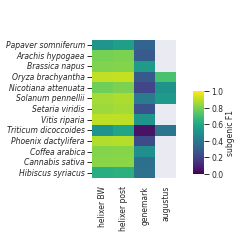

In [16]:
heatmap(plant_3[0].iloc[:,9:], group, busco_ref_sort_plant, lab='subgenic F1', dpi=55)

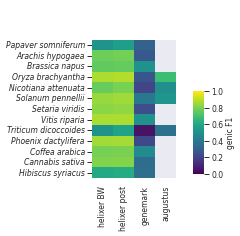

In [17]:
heatmap(plant_3[1].iloc[:,9:], group, busco_ref_sort_plant, lab='genic F1', dpi=55)

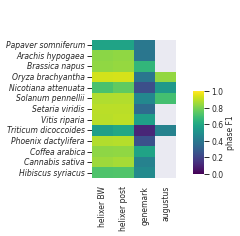

In [18]:
heatmap(plant_3[2].iloc[:,9:], group, busco_ref_sort_plant, lab='phase F1', dpi=55)

Now we load the lineage (group) information for every species, as well as just the F1 scores.

In [19]:
subgenics = pd.concat([load_and_extract3(group)[0].iloc[:,[0, 9, 10, 11, 12]]
                       for group in ['fungi', 'plant', 'vertebrate', 'invertebrate']])
genics = pd.concat([load_and_extract3(group)[1].iloc[:,[0, 9, 10, 11, 12]]
                    for group in ['fungi', 'plant', 'vertebrate', 'invertebrate']])
phases = pd.concat([load_and_extract3(group)[2].iloc[:,[0, 9, 10, 11, 12]]
                    for group in ['fungi', 'plant', 'vertebrate', 'invertebrate']])

In [20]:
busco_ref_sort = ['Neurospora_crassa', 'Coccidioides_immitis', 'Fusarium_graminearum',
       'Debaryomyces_hansenii', 'Aspergillus_terreus', 'Laccaria_bicolor',
       'Papaver_somniferum', 'Arachis_hypogaea', 'Brassica_napus',
       'Oryza_brachyantha', 'Nicotiana_attenuata', 'Solanum_pennellii',
       'Setaria_viridis', 'Vitis_riparia', 'Triticum_dicoccoides',
       'Phoenix_dactylifera', 'Coffea_arabica', 'Cannabis_sativa',
       'Hibiscus_syriacus', 'Balaenoptera_musculus', 'Xiphias_gladius',
       'Sparus_aurata', 'Desmodus_rotundus', 'Pseudonaja_textilis',
       'Falco_naumanni', 'Chiroxiphia_lanceolata', 'Myotis_davidii',
       'Lagopus_leucura', 'Rhincodon_typus', 'Opisthocomus_hoazin',
       'Bombus_impatiens', 'Tribolium_castaneum', 'Drosophila_virilis',
       'Apis_dorsata', 'Frankliniella_occidentalis', 'Trachymyrmex_cornetzi',
       'Drosophila_albomicans', 'Ctenocephalides_felis', 'Atta_cephalotes',
       'Rhopalosiphum_maidis', 'Culex_pipiens', 'Hyposmocoma_kahamanoa',
       'Caenorhabditis_remanei', 'Schistosoma_mansoni',
       'Opisthorchis_viverrini']

We will reorder the species, so the order is identical to the BUSCO plots. The columns `helixer` and `helixer_post` are renamed to `helixer BW` (base-wise) and `helixer post` respectively.

In [21]:
def reorder_df(df, sort_order):
    df = pd.DataFrame(df.iloc[:, [0,1,2,3,4]])
    df = df.rename({'helixer': 'helixer BW', 'helixer_post': 'helixer post'}, axis=1)
    df_reorder = df.loc[sort_order, :]
    return df_reorder

In [22]:
subgenics = reorder_df(subgenics, busco_ref_sort)
genics = reorder_df(genics, busco_ref_sort)
phases = reorder_df(phases, busco_ref_sort)

In [23]:
def plot_f1_summary(df_reorder, figsize=(2.5,4.5), dpi=100, ylab="Genic F1", fsize=10, figname='filler'):
    # set colors
    cmap=plt.get_cmap("Set1")
    x = [8, 1, 0, 2]  # 2=green, 8=grey, 0=red, 1=blue
    colors = np.array(cmap.colors)[np.array(x)]
    
    # order colors to match 
    key={'invertebrate': 0, 'vertebrate': 2, 'fungi': 1, 'plant': 3}
    newc = [colors[key[x]] for x in df_reorder['group']]
    
    # main plot
    # -----------
    sns.set_theme(rc={'figure.dpi': dpi})
    sns.set_style("dark")  # options: white, dark, whitegrid, darkgrid, ticks (heatmap background/missing data values)
    cg = sns.clustermap(df_reorder.iloc[:,1:], cmap='viridis', vmin=0, vmax=1,
                        cbar_kws={'label': ylab, 'fraction': 0.07},
                        row_cluster=False, yticklabels=False, col_cluster=False, row_colors=newc,
                        figsize=figsize, cbar_pos=(1, 0.35, 0.1, 0.3), 
                        colors_ratio=0.07)
    
    ylabs, start, lengths = np.unique(df_reorder['group'], return_counts=True, return_index=True)
    
    cg.ax_row_colors.set_yticks(start + lengths // 2)
    cg.ax_row_colors.set_yticklabels(ylabs, rotation=60, size=fsize)
    cg.ax_heatmap.set_xticklabels([method[1] for i, method in enumerate(df_reorder.columns) if i != 0], fontsize = fsize)
    cg.ax_heatmap.set_xlabel('')
    
    # save figure
    #cg.savefig(f"joint/{figname}.pdf")
    #cg.savefig(f"joint/{figname}.eps")

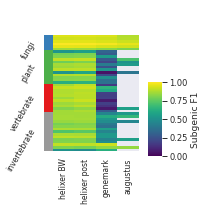

In [24]:
plot_f1_summary(subgenics, ylab='Subgenic F1', dpi=55)

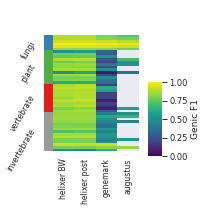

In [25]:
plot_f1_summary(genics, dpi=55)

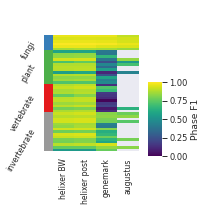

In [26]:
plot_f1_summary(phases, ylab='Phase F1', dpi=55)

## Export tables
Lastly, we can directly export the created dataframes to LaTeX tables.

In [ ]:
subgenics = pd.concat([load_and_extract3(group)[0]
                       for group in ['fungi', 'plant', 'vertebrate', 'invertebrate']])
genics = pd.concat([load_and_extract3(group)[1]
                    for group in ['fungi', 'plant', 'vertebrate', 'invertebrate']])
phases = pd.concat([load_and_extract3(group)[2]
                    for group in ['fungi', 'plant', 'vertebrate', 'invertebrate']])

In [27]:
subgenics.style.to_latex('joint/subgenic_f1.tex')
genics.style.to_latex('joint/genic_f1.tex')
phases.style.to_latex('joint/phase_f1.tex')